Note: this notebook uses a few libraries not in the `environment.yml` of this repo. It requires configuring and setting up [PUDL](https://github.com/catalyst-cooperative/pudl) version 0.5 or 0.6, which is more complicated than a `conda install`. I didn't want to require that unless this dataset was actually used.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import pathlib
import sys

# 3rd party libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa

# Local libraries
import pudl
import pudl.output.ferc714

# Configure Display Parameters

In [3]:
sns.set()
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Use Python Logging facilities
* Using a logger from the beginning will make the transition into the PUDL package easier.
* Creating a logging handler here will also allow you to see the logging output coming from PUDL and other underlying packages.

In [4]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Define Functions

# Define Notebook Parameters

In [5]:
pudl_settings = pudl.workspace.setup.get_defaults()
display(pudl_settings)

ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
display(ferc1_engine)

pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
display(pudl_engine)

{'pudl_in': '/home/tpb/catalyst/workspace',
 'data_dir': '/home/tpb/catalyst/workspace/data',
 'settings_dir': '/home/tpb/catalyst/workspace/settings',
 'pudl_out': '/home/tpb/catalyst/workspace',
 'sqlite_dir': '/home/tpb/catalyst/workspace/sqlite',
 'parquet_dir': '/home/tpb/catalyst/workspace/parquet',
 'ferc1_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/pudl.sqlite',
 'censusdp1tract_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/censusdp1tract.sqlite'}

Engine(sqlite:////home/tpb/catalyst/workspace/sqlite/ferc1.sqlite)

Engine(sqlite:////home/tpb/catalyst/workspace/sqlite/pudl.sqlite)

# Load Data

In [6]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine=pudl_engine, start_date='2018-01-01', end_date='2018-12-31')

In [7]:
county_gdf = pudl.output.censusdp1tract.get_layer(
        layer="county", pudl_settings=pudl_settings
    )

Census DP1 SQLite DB is missing. Creating it.
Extracting the Census DP1 GeoDB to /home/tpb/catalyst/workspace/sqlite/censusdp1tract.sqlite
extract_root = /tmp/tmpn5ew4zfs/Profile-County_Tract.gdb
out_path = /home/tpb/catalyst/workspace/sqlite/censusdp1tract.sqlite


In [8]:
kwargs_dicts = [
        {"entity_type": "util", "limit_by_state": False},
        {"entity_type": "util", "limit_by_state": True},
        {"entity_type": "ba", "limit_by_state": True},
        {"entity_type": "ba", "limit_by_state": False},
    ]

In [9]:
%%time
util = pudl.analysis.service_territory.compile_geoms(
    pudl_out,
    census_counties=county_gdf,
    dissolve=True,
    save=False,
    **kwargs_dicts[0],
)

Compiling util geometries with dissolve=True and limit_by_state=False.
Running the interim EIA 861 ETL process!
Extracting eia861 spreadsheet data.


/home/tpb/catalyst/pudl/src/pudl/extract/eia861.py:37: UserWarning: Integration of EIA 861 into PUDL is still experimental and incomplete.
The data has not yet been validated, and the structure may change.
  warnings.warn(


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Transforming raw EIA 861 DataFrames for advanced_metering_infrastructure_eia861 concatenated across all years.
Tidying the E

In [10]:
pudl.analysis.service_territory.plot_all_territories(util, report_date=pd.Timestamp('2018-01-01'), respondent_type='balancing_authority')

UndefinedVariableError: name 'respondent_id_ferc714' is not defined

In [11]:
util.columns

Index(['report_date', 'utility_id_eia', 'geometry', 'population', 'area_km2'], dtype='object')

In [12]:
util.memory_usage(deep=True) / 2**20

Index             0.402328
report_date       0.402328
utility_id_eia    0.402328
geometry          0.402328
population        0.402328
area_km2          0.402328
dtype: float64

In [23]:
util.describe(datetime_is_numeric=True)

,report_date,utility_id_eia,population,area_km2
count,52734,52734.000000,5.273400e+04,5.273400e+04
mean,2009-11-19 08:45:03.379224064,11918.782342,4.456301e+05,1.375926e+04
min,2001-01-01 00:00:00,34.000000,0.000000e+00,0.000000e+00
25%,2005-01-01 00:00:00,5827.250000,2.820500e+04,1.697995e+03
50%,2009-01-01 00:00:00,11479.000000,9.745100e+04,3.703308e+03
75%,2015-01-01 00:00:00,16751.000000,3.348110e+05,1.202020e+04
max,2020-01-01 00:00:00,64196.000000,2.960877e+07,1.535564e+06
std,NaN,8133.531741,1.264544e+06,3.991504e+04


In [13]:
util.shape

(52734, 5)

In [15]:
date_condition = util['report_date'] == pd.Timestamp('2018-01-01')
unwanted_respondent_ids = (  # noqa: F841 variable is used, in df.query() below
        112,  # Alaska
        133,  # Alaska
        178,  # Hawaii
        301,  # PJM Dupe
        302,  # PJM Dupe
        303,  # PJM Dupe
        304,  # PJM Dupe
        305,  # PJM Dupe
        306,  # PJM Dupe
    )
wanted_condition = ~util['utility_id_eia'].isin(set(unwanted_respondent_ids))

subset = util.loc[date_condition & wanted_condition,:]
subset.shape

(2198, 5)

<AxesSubplot:>

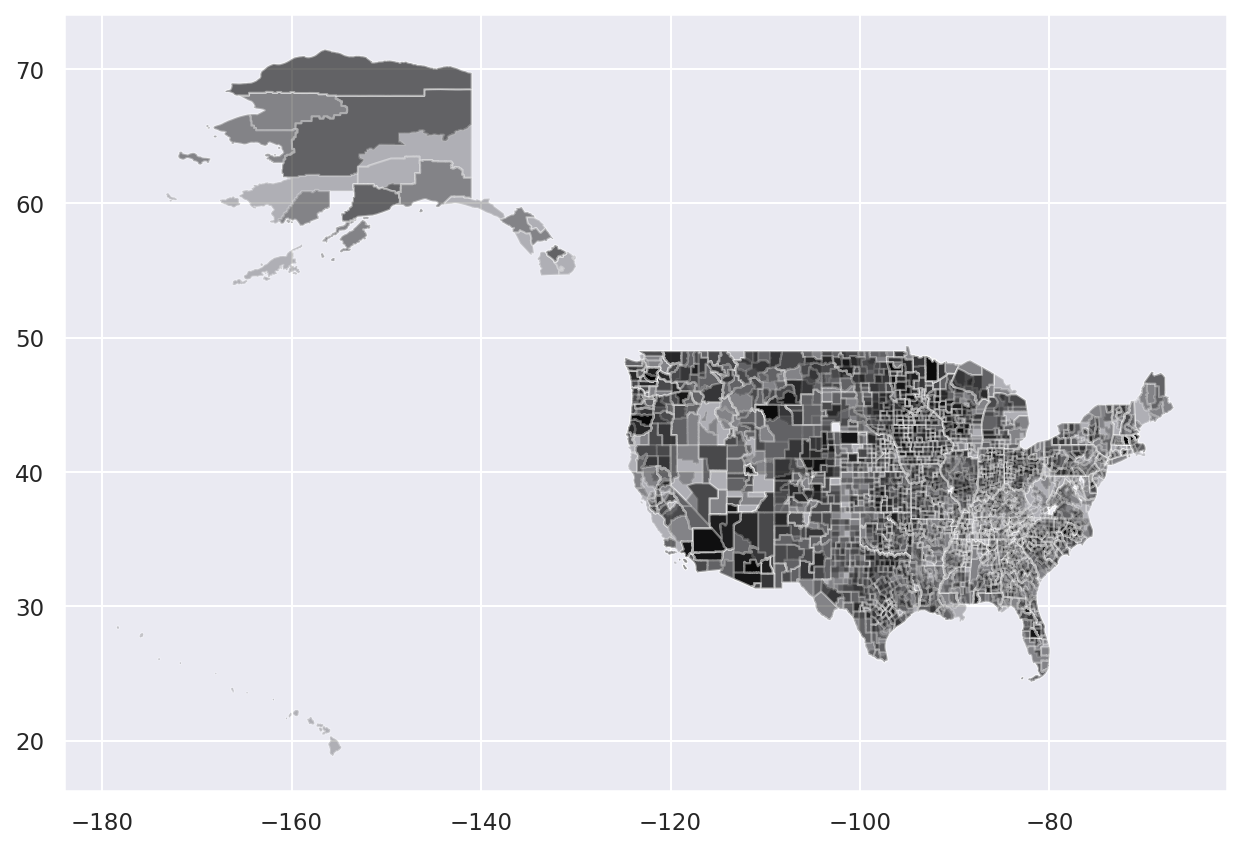

In [21]:
subset.plot(figsize=(10, 10), color='black', alpha=0.25, linewidth=1)

In [24]:
%%time
ferc714_out = pudl.output.ferc714.Respondents(pudl_out)
annualized = ferc714_out.annualize()
categorized = ferc714_out.categorize()
summarized = ferc714_out.summarize_demand()
fipsified = ferc714_out.fipsify()
counties_gdf = ferc714_out.georef_counties()

Running the interim FERC 714 ETL process!
Extracting demand_hourly_pa_ferc714 from CSV into pandas DataFrame.


/home/tpb/catalyst/pudl/src/pudl/extract/ferc714.py:62: UserWarning: Integration of FERC 714 into PUDL is still experimental and incomplete.
The data has not yet been validated, and the structure may change.
  warnings.warn(


Extracting respondent_id_ferc714 from CSV into pandas DataFrame.
Transforming demand_hourly_pa_ferc714.
Transforming respondent_id_ferc714.
CPU times: user 26.7 s, sys: 14.9 s, total: 41.7 s
Wall time: 42.8 s


In [25]:
annualized

,respondent_id_ferc714,respondent_name_ferc714,eia_code,report_date
0,101,PowerSouth Energy Cooperative (Alabama Electri...,189,2006-01-01
1,101,PowerSouth Energy Cooperative (Alabama Electri...,189,2007-01-01
2,101,PowerSouth Energy Cooperative (Alabama Electri...,189,2008-01-01
3,101,PowerSouth Energy Cooperative (Alabama Electri...,189,2009-01-01
4,101,PowerSouth Energy Cooperative (Alabama Electri...,189,2010-01-01
...,...,...,...,...
3190,331,GridLiance,<NA>,2016-01-01
3191,331,GridLiance,<NA>,2017-01-01
3192,331,GridLiance,<NA>,2018-01-01
3193,331,GridLiance,<NA>,2019-01-01


In [26]:
categorized

,eia_code,respondent_type,respondent_id_ferc714,respondent_name_ferc714,report_date,balancing_authority_id_eia,balancing_authority_code_eia,balancing_authority_name_eia,utility_id_eia,utility_name_eia
0,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>
1,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2007-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>
2,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2008-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>
3,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2009-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>
4,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2010-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...
3190,<NA>,<NA>,331,GridLiance,2016-01-01,<NA>,<NA>,<NA>,<NA>,<NA>
3191,<NA>,<NA>,331,GridLiance,2017-01-01,<NA>,<NA>,<NA>,<NA>,<NA>
3192,<NA>,<NA>,331,GridLiance,2018-01-01,<NA>,<NA>,<NA>,<NA>,<NA>
3193,<NA>,<NA>,331,GridLiance,2019-01-01,<NA>,<NA>,<NA>,<NA>,<NA>


In [27]:
summarized

,report_date,respondent_id_ferc714,demand_annual_mwh,population,area_km2,population_density_km2,demand_annual_per_capita_mwh,demand_density_mwh_km2,eia_code,respondent_type,respondent_name_ferc714,balancing_authority_id_eia,balancing_authority_code_eia,balancing_authority_name_eia,utility_id_eia,utility_name_eia
0,2006-01-01,101,8875388.27,3113764.0,102032.132718,30.517484,2.850373,86.986208,189,balancing_authority,PowerSouth Energy Cooperative (Alabama Electri...,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>
1,2006-01-01,102,64585325.00,3938281.0,120381.470768,32.715010,16.399369,536.505532,195,utility,Alabama Power Company,<NA>,<NA>,<NA>,195,Alabama Power Co
2,2006-01-01,103,41192.21,0.0,0.000000,NaN,inf,inf,317,balancing_authority,Cube Hydro Carolinas Yadkin,317,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",<NA>,<NA>
3,2006-01-01,104,12844341.60,1008730.0,113056.646599,8.922341,12.733181,113.609788,12647,balancing_authority,Allete (Minnesota Power),12647,<NA>,"Minnesota Power, Inc",<NA>,<NA>
4,2006-01-01,105,14564695.00,2473570.0,72214.223451,34.253224,5.888127,201.687345,20856,utility,Alliant Energy-East,<NA>,<NA>,<NA>,20856,Wisconsin Power & Light Co
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,2020-01-01,327,0.00,0.0,0.000000,NaN,NaN,NaN,19804,utility,City of Vero Beach,<NA>,<NA>,<NA>,19804,City of Vero Beach
3191,2020-01-01,328,10642343.00,0.0,0.000000,NaN,inf,inf,13100,utility,Municipal Electric Authority of Georgia,<NA>,<NA>,<NA>,13100,Municipal Electric Authority
3192,2020-01-01,329,3785514.00,0.0,0.000000,NaN,inf,inf,39347,utility,East Texas Electric Cooperative,<NA>,<NA>,<NA>,39347,"East Texas Electric Coop, Inc"
3193,2020-01-01,330,0.00,0.0,0.000000,NaN,NaN,NaN,14369,utility,Avangrid Renewables,<NA>,<NA>,<NA>,14369,PCA-Tomahawk Mill


In [69]:
u = summarized.loc[summarized['respondent_name_ferc714'].str.lower().str.contains("tacoma"),:].sort_values('report_date').set_index('report_date')

<AxesSubplot:xlabel='report_date'>

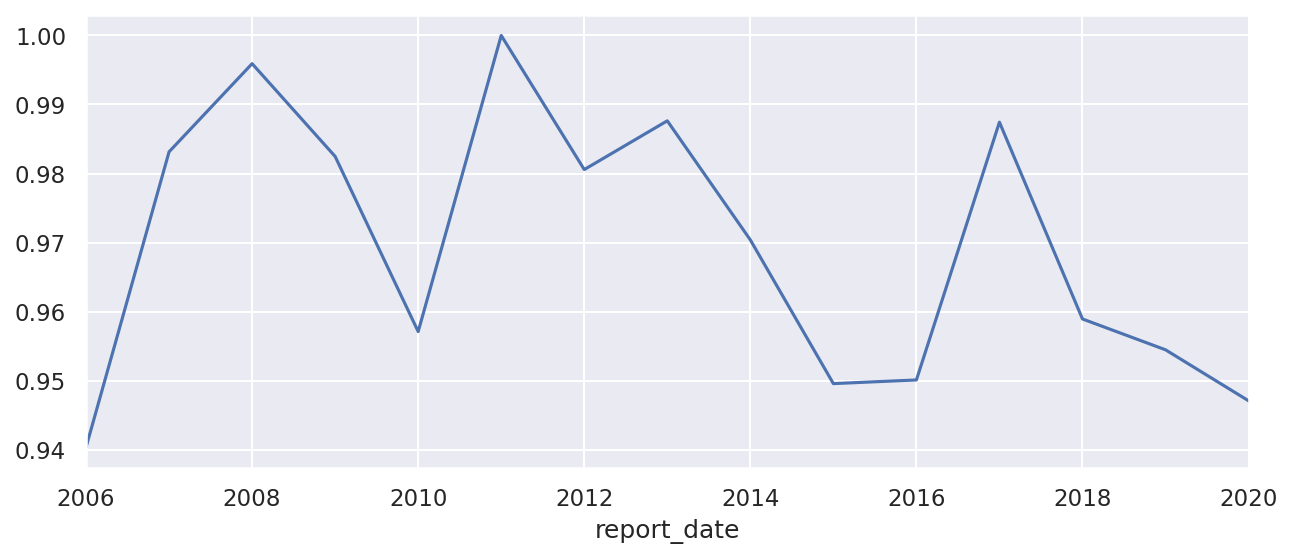

In [71]:
u['demand_annual_mwh'].div(u['demand_annual_mwh'].max()).plot()

In [28]:
fipsified

,eia_code,respondent_type,respondent_id_ferc714,respondent_name_ferc714,report_date,balancing_authority_id_eia,balancing_authority_code_eia,balancing_authority_name_eia,utility_id_eia,utility_name_eia,state,county,state_id_fips,county_id_fips
0,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Covington,01,01039
1,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Baldwin,01,01003
2,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Monroe,01,01099
3,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Pike,01,01109
4,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Coosa,01,01037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,<NA>,<NA>,331,GridLiance,2016-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3191,<NA>,<NA>,331,GridLiance,2017-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3192,<NA>,<NA>,331,GridLiance,2018-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3193,<NA>,<NA>,331,GridLiance,2019-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [29]:
counties_gdf

,county_id_fips,county_name_census,population,geometry,area_km2,eia_code,respondent_type,respondent_id_ferc714,respondent_name_ferc714,report_date,balancing_authority_id_eia,balancing_authority_code_eia,balancing_authority_name_eia,utility_id_eia,utility_name_eia,state,county,state_id_fips
0,01039,Covington County,37765.0,"MULTIPOLYGON (((-86.27605 31.45560, -86.26660 ...",2703.392410,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Covington,01
1,01003,Baldwin County,182265.0,"MULTIPOLYGON (((-87.61542 31.04100, -87.61542 ...",5250.710922,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Baldwin,01
2,01099,Monroe County,23068.0,"MULTIPOLYGON (((-87.57700 31.43210, -87.57587 ...",2679.123044,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Monroe,01
3,01109,Pike County,32899.0,"MULTIPOLYGON (((-86.14711 31.66300, -86.14715 ...",1743.077616,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Pike,01
4,01037,Coosa County,11539.0,"MULTIPOLYGON (((-86.44784 32.85098, -86.44763 ...",1725.837932,189,balancing_authority,101,PowerSouth Energy Cooperative (Alabama Electri...,2006-01-01,189,AEC,Alabama Electric Coop Inc,<NA>,<NA>,AL,Coosa,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136089,<NA>,NaN,NaN,None,NaN,<NA>,<NA>,331,GridLiance,2016-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
136090,<NA>,NaN,NaN,None,NaN,<NA>,<NA>,331,GridLiance,2017-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
136091,<NA>,NaN,NaN,None,NaN,<NA>,<NA>,331,GridLiance,2018-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
136092,<NA>,NaN,NaN,None,NaN,<NA>,<NA>,331,GridLiance,2019-01-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [30]:
categorized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3195 entries, 0 to 3194
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   eia_code                      3165 non-null   Int64         
 1   respondent_type               2790 non-null   string        
 2   respondent_id_ferc714         3195 non-null   Int64         
 3   respondent_name_ferc714       3195 non-null   string        
 4   report_date                   3195 non-null   datetime64[ns]
 5   balancing_authority_id_eia    1875 non-null   Int64         
 6   balancing_authority_code_eia  1260 non-null   string        
 7   balancing_authority_name_eia  1875 non-null   string        
 8   utility_id_eia                915 non-null    Int64         
 9   utility_name_eia              915 non-null    string        
dtypes: Int64(4), datetime64[ns](1), string(5)
memory usage: 287.1 KB


In [31]:
summarized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3195 entries, 0 to 3194
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   report_date                   3195 non-null   datetime64[ns]
 1   respondent_id_ferc714         3195 non-null   Int64         
 2   demand_annual_mwh             3195 non-null   float64       
 3   population                    3195 non-null   float64       
 4   area_km2                      3195 non-null   float64       
 5   population_density_km2        1746 non-null   float64       
 6   demand_annual_per_capita_mwh  2186 non-null   float64       
 7   demand_density_mwh_km2        2186 non-null   float64       
 8   eia_code                      3165 non-null   Int64         
 9   respondent_type               2790 non-null   string        
 10  respondent_name_ferc714       3195 non-null   string        
 11  balancing_authority_id_eia    

In [32]:
fipsified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136094 entries, 0 to 3194
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   eia_code                      136064 non-null  Int64         
 1   respondent_type               135689 non-null  string        
 2   respondent_id_ferc714         136094 non-null  Int64         
 3   respondent_name_ferc714       136094 non-null  string        
 4   report_date                   136094 non-null  datetime64[ns]
 5   balancing_authority_id_eia    124582 non-null  Int64         
 6   balancing_authority_code_eia  113869 non-null  string        
 7   balancing_authority_name_eia  124582 non-null  string        
 8   utility_id_eia                11107 non-null   Int64         
 9   utility_name_eia              11107 non-null   string        
 10  state                         134646 non-null  string        
 11  county         

In [33]:
counties_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 136094 entries, 0 to 136093
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   county_id_fips                134598 non-null  string        
 1   county_name_census            134569 non-null  object        
 2   population                    134569 non-null  float64       
 3   geometry                      134569 non-null  geometry      
 4   area_km2                      134569 non-null  float64       
 5   eia_code                      136064 non-null  Int64         
 6   respondent_type               135689 non-null  string        
 7   respondent_id_ferc714         136094 non-null  Int64         
 8   respondent_name_ferc714       136094 non-null  string        
 9   report_date                   136094 non-null  datetime64[ns]
 10  balancing_authority_id_eia    124582 non-null  Int64         
 11  balan

In [72]:
%time demand = pudl_out.demand_hourly_pa_ferc714()

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.2 µs


In [73]:
demand.head()

,respondent_id_ferc714,report_date,utc_datetime,timezone,demand_mwh
365,206,2006-01-01,2006-01-01 08:00:00,America/Los_Angeles,204.0
366,206,2006-01-01,2006-01-02 08:00:00,America/Los_Angeles,193.0
367,206,2006-01-01,2006-01-03 08:00:00,America/Los_Angeles,218.0
368,206,2006-01-01,2006-01-04 08:00:00,America/Los_Angeles,230.0
369,206,2006-01-01,2006-01-05 08:00:00,America/Los_Angeles,234.0


In [74]:
demand.describe(datetime_is_numeric=True)

,respondent_id_ferc714,report_date,utc_datetime,demand_mwh
count,1.560815e+07,15608154,15608154,1.560815e+07
mean,2.098245e+02,2012-03-08 04:16:48.076785920,2012-09-06 23:28:32.369188096,4.192537e+03
min,1.010000e+02,2006-01-01 00:00:00,2006-01-01 05:00:00,-1.000000e+02
25%,1.630000e+02,2008-01-01 00:00:00,2008-10-01 11:00:00,3.450000e+02
50%,2.140000e+02,2012-01-01 00:00:00,2012-04-17 00:00:00,1.059000e+03
75%,2.570000e+02,2016-01-01 00:00:00,2016-05-24 08:00:00,2.749000e+03
max,3.290000e+02,2020-01-01 00:00:00,2021-01-01 09:00:00,1.580430e+05
std,5.721115e+01,NaN,NaN,1.117705e+04


In [75]:
demand.shape

(15608154, 5)

In [76]:
demand.nunique()

respondent_id_ferc714       181
report_date                  15
utc_datetime             131501
timezone                      6
demand_mwh               654205
dtype: int64

In [77]:
by_respondent = demand.groupby('respondent_id_ferc714')[['utc_datetime', 'demand_mwh']].agg(['count', 'min', 'max'])

In [78]:
by_respondent

utc_datetime                                         demand_mwh                   
                             count                 min                 max      count      min       max
respondent_id_ferc714                                                                                   
101                         131496 2006-01-01 06:00:00 2021-01-01 05:00:00     131496      0.0    2458.0
102                         131496 2006-01-01 06:00:00 2021-01-01 05:00:00     131496   4040.0   12496.0
103                           8760 2006-01-01 05:00:00 2007-01-01 04:00:00       8760      1.3      25.8
104                          26304 2006-01-01 06:00:00 2009-01-01 05:00:00      26304   1097.7    1757.7
105                          26304 2006-01-01 06:00:00 2009-01-01 05:00:00      26304      0.0    2941.0
...                            ...                 ...                 ...        ...      ...       ...
308                         131496 2006-01-01 05:00:00 2021-01-01 04:00:00     131496      0.0     361.0
311                          17544 2007-01-01 06:00:00 2013-01-01 05:00:00      17544    763.0    2908.0
321                         105192 2009-01-01 05:00:00 2021-01-01 04:00:00     105192  37263.0  120124.0
328                          61368 2014-01-01 05:00:00 2021-01-01 04:00:00      61368    703.0    2071.0
329                          35064 2017-01-01 06:00:00 2021-01-01 05:00:00      35064    224.0    1839.0

[181 rows x 6 columns]

<AxesSubplot:>

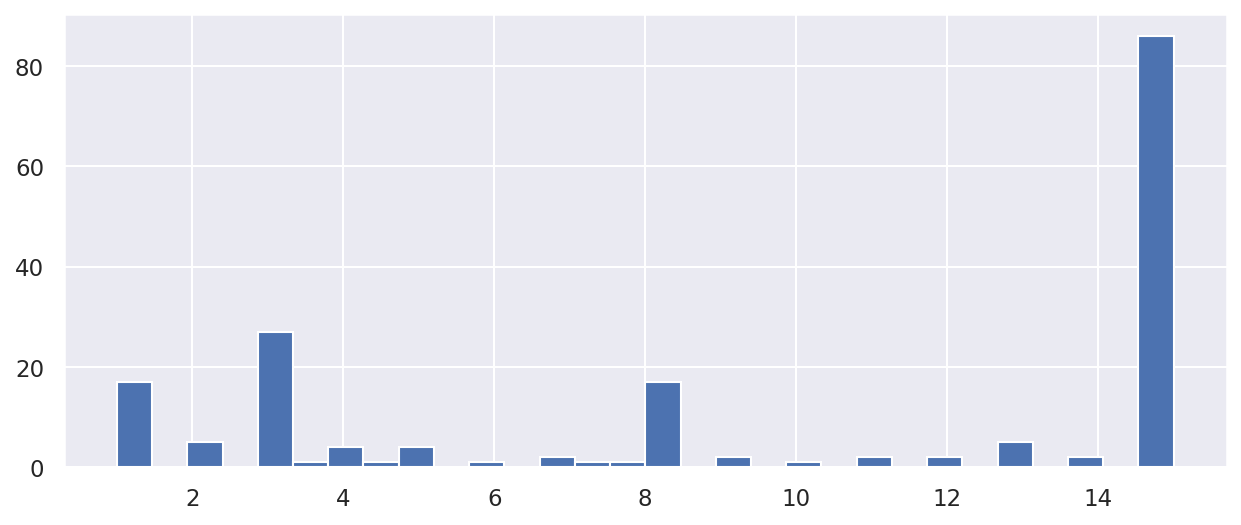

In [85]:
by_respondent.loc[:,('demand_mwh', 'count')].div(8766).hist(bins=30)

In [88]:
sdge = demand.loc[demand['respondent_id_ferc714'].eq(246),:].set_index('utc_datetime').sort_index()

<AxesSubplot:xlabel='utc_datetime'>

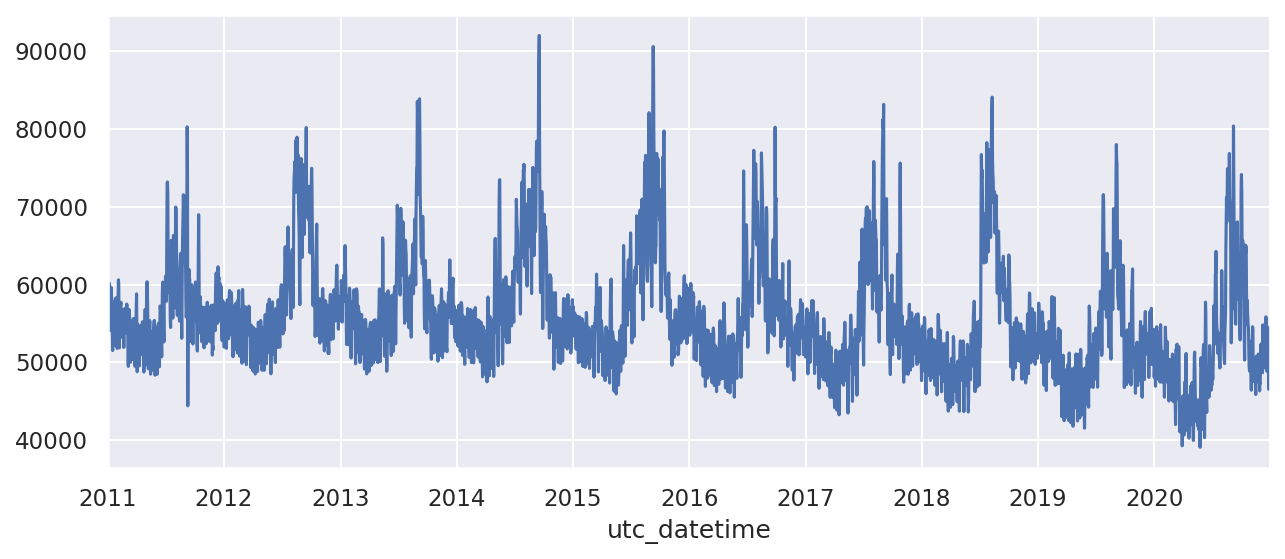

In [91]:
sdge.loc['2011':'2020', 'demand_mwh'].resample('1d').sum().plot()

<AxesSubplot:xlabel='utc_datetime'>

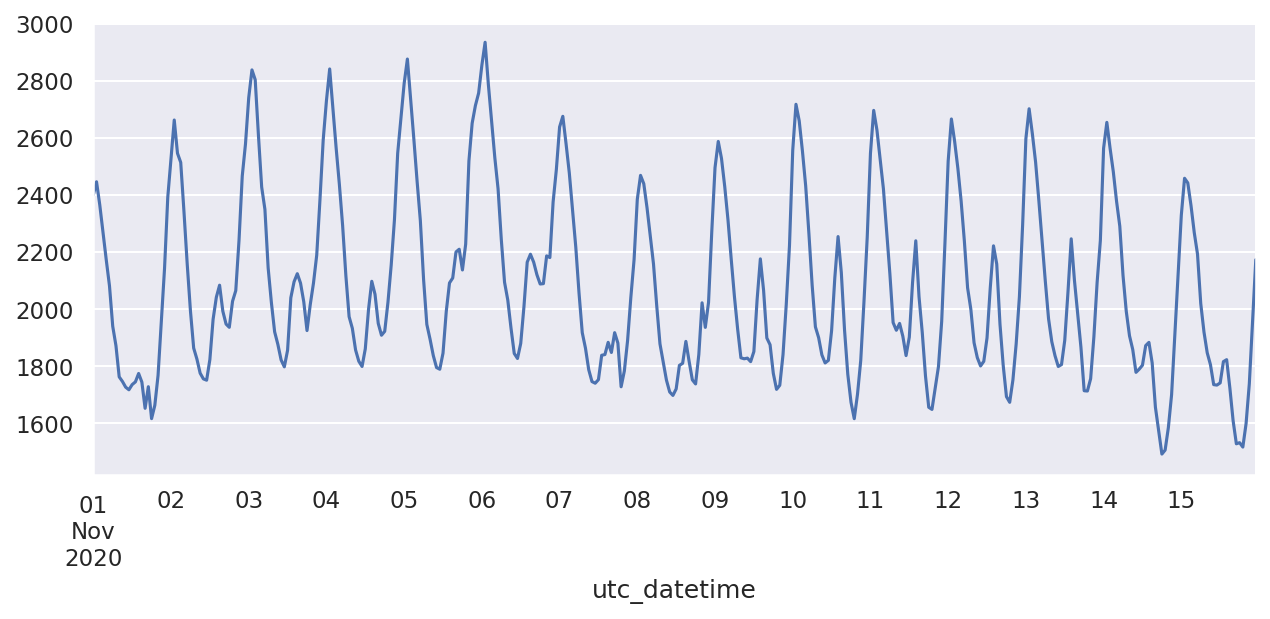

In [93]:
sdge.loc['2020-11-01':'2020-11-15', 'demand_mwh'].plot()